# ESG disclosures vs. investment metrics

ESG (Environmental, Social & Governance) is a data set that is increasingly being factored into investment making decisions by financial market participants. However to date there's little to no standardization in the market for ESG reporting. There's no single standard list of ESG metrics used by companies, governments, self-regulating bodies or investors. ESG disclosures are largely voluntary and the list of ESG metrics a company reports varies greatly from one company to another, even if one looks at similar size companies from the same industry and geography.

In this notebook we're examining the relationship between the number of ESG disclosures a company makes and investment metrics such as Alpha or Return on Assets.

In [1]:
# Imports and setting up app key to be able to use LSEG Data Library for Python.
import pandas as pd
import datetime as dt
import lseg.data as ld
import matplotlib
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
# replace the code below with ld.open_session(app_key = APP_KEY) call using app key generated by you
import os
APP_KEY = os.environ.get('APP_KEY')
if APP_KEY==None:
    print('App key is needed to retrieve data from LSEG Workspace. Generate your app key and use it in ld.open_session call.')
else:    
    ld.open_session(app_key = APP_KEY)

In the next cell we use Screener to retrieve the list of companies headquartered in the US, falling into Industrials economic sector according to TRBC sector classification scheme (the value of TR.TRBCEconSectorCode field equals 52) and with market cap over 10 billion USD. This code can be easily modified to use 
- other criteria with Screener
- to retrieve constituents of an index, e.g. 
ld.get_data('0#.SPX','DSPLY_NAME')['Instrument'].tolist() 
returns the constituents of S&P 500
- import portfolio setup in Workspace
- import custom list of stocks

In [2]:
screener_exp = '''SCREEN(U(IN(Equity(active,public,primary))), IN(TR.HQCountryCode,"US"),
 IN(TR.TRBCEconSectorCode,"52"), TR.CompanyMarketCap>=10000000000, CURN=USD)'''
instr = ld.get_data(screener_exp,'DSPLY_NAME')['Instrument'].tolist()
#Remove duplicates, None and empty strings from the list
instr = list(dict.fromkeys(instr))
instr = list(filter(None, instr))
instr = list(filter(str.strip, instr))

ESGFieldCategories.csv file contains the list of ESG fields split between several categories. The two categories we're using in this notebook are Performance (where a company reports on how it performs against the metric) and Policy (where a company states whether it has specific policy without disclosing how it's performing against it). Then we retrieve these fields for the list of stocks constructed in the previous cell.

In [3]:
esg_fields_df = pd.read_csv('ESGFieldCategories.csv')
perf_fields = esg_fields_df['Performance'].dropna().tolist()
pol_fields = esg_fields_df['Policy'].dropna().tolist()
df_perf = ld.get_data(instr, perf_fields)
df_perf.set_index('Instrument', inplace = True)
df_pol = ld.get_data(instr, pol_fields)
df_pol.set_index('Instrument', inplace = True)

C:\Python312\Lib\site-packages\pandas\core\dtypes\cast.py:1056:RuntimeWarning: invalid value encountered in cast
C:\Python312\Lib\site-packages\pandas\core\dtypes\cast.py:1080:RuntimeWarning: invalid value encountered in cast
C:\Python312\Lib\site-packages\pandas\core\dtypes\cast.py:1056:RuntimeWarning: invalid value encountered in cast
C:\Python312\Lib\site-packages\pandas\core\dtypes\cast.py:1080:RuntimeWarning: invalid value encountered in cast
C:\Python312\Lib\site-packages\pandas\core\dtypes\cast.py:1056:RuntimeWarning: invalid value encountered in cast
C:\Python312\Lib\site-packages\pandas\core\dtypes\cast.py:1080:RuntimeWarning: invalid value encountered in cast


Now from our list of companies we select top 20% by the number of disclosures on performance and policy metrics. Here we only consider whether specific metric is populated for the company, not the value of the metric or its polarity (whether a higher score is "good" or "bad"). For performance metrics we're counting all values that are non-NA and not empty strings. For policy metrics we're only counting values that are True because for these metrics values that are False or empty have the same meaning: companies never resport that they don't have a specific policy, they only disclose the policies they do have.

In [4]:
# determine top 20% of the companies by disclosure on performance metrics
best_stocks_by_perf_df = (df_perf.count(axis=1) - (df_perf == '').sum(axis=1)).nlargest(int(len(instr)/5))
best_stocks_by_perf_df

Instrument
IR.N      115
HWM.N     115
RSG.N     113
LMT.N     112
SPGI.N    112
J.N       109
XPO.N     108
BA.N      107
NSC.N     107
WM.N      106
NOC.N     106
GWW.N     105
FDX.N     105
EMR.N     104
RTX.N     104
XYL.N     103
UNP.N     103
LUV.N     101
dtype: Int64

In [6]:
# determine top 20% of the companies by disclosure on policy metrics
best_stocks_by_pol_df = (df_pol == True).sum(axis=1).nlargest(int(len(instr)/5))
best_stocks_by_pol_df

Instrument
GE.N       111
XYL.N      106
RTX.N      104
LMT.N      103
HWM.N      103
CAT.N      102
EMR.N      102
BA.N       100
SPGI.N     100
ITT.N       99
LECO.OQ     98
CARR.N      98
WAB.N       97
WM.N        96
J.N         96
RSG.N       96
MCO.N       95
VRT.N       95
dtype: Int64

The lists of top 20% of companies by the number of disclosures on performance and policy metrics will generally not be the same, however it's likely that there will be an overlap between the two lists. 

In [10]:
# Calculate the overlap between top 20% by performance and policy metrics
best_stocks_by_perf_list = best_stocks_by_perf_df.index.tolist()
best_stocks_by_pol_list = best_stocks_by_pol_df.index.tolist()
print('The overlap between top 20% by disclosure on performance metrics and on policy metrics:')
print("{0:.0%}".format(len([x for x in best_stocks_by_perf_list if x in best_stocks_by_pol_list])
                       /len(best_stocks_by_pol_list)))

The overlap between top 20% by disclosure on performance metrics and on policy metrics:
56%


Now we can compare the averages of investing metrics between the lists of top 20% by the number of populated ESG policy and performance metrics vs. the full universe of stocks in our research. For this universe of stocks (large cap US industrials) we can conclude that a higher number of ESG disclosures does not translate into better stock price performance measured by Alpha or Sharpe ratio. However it appears that stocks with the highest number of ESG disclosures significantly outperform its peers on profitability measures such as return on equity and return on assets. We can also see that the number of disclosures on performance metrics is of much greater significance than the number of disclosures on policy metrics.

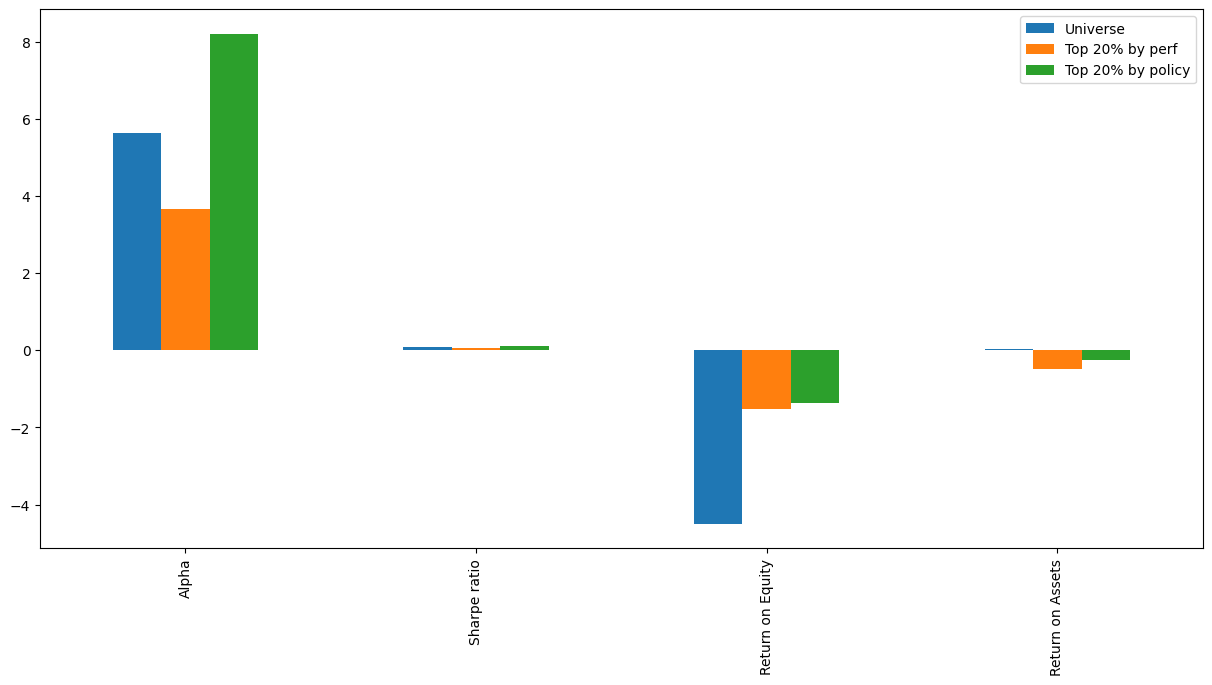

In [11]:
univ_df = ld.get_data(instr,['GAVG(TR.AlphaMthly5Y,universe="univ")',
                                  'GAVG(TR.SharpeRatioMthly5Y,universe="univ")',
                                  'GAVG(TR.InvtrReturnOnEquity,universe="univ")',
                                  'GAVG(TR.InvtrReturnOnAssets,universe="univ")'])
perf_df = ld.get_data(best_stocks_by_perf_list,['GAVG(TR.AlphaMthly5Y,universe="univ")',
                                                     'GAVG(TR.SharpeRatioMthly5Y,universe="univ")',
                                                     'GAVG(TR.InvtrReturnOnEquity,universe="univ")',
                                                     'GAVG(TR.InvtrReturnOnAssets,universe="univ")'])
pol_df = ld.get_data(best_stocks_by_pol_list,['GAVG(TR.AlphaMthly5Y,universe="univ")',
                                                   'GAVG(TR.SharpeRatioMthly5Y,universe="univ")',
                                                   'GAVG(TR.InvtrReturnOnEquity,universe="univ")',
                                                   'GAVG(TR.InvtrReturnOnAssets,universe="univ")'])
plot_df = pd.DataFrame({'Universe': univ_df.iloc[0,1:].tolist(),
                       'Top 20% by perf': perf_df.iloc[0,1:].tolist(),
                       'Top 20% by policy': pol_df.iloc[0,1:].tolist()},
                      index=['Alpha','Sharpe ratio','Return on Equity','Return on Assets'])
ax = plot_df.plot.bar(figsize=(15,7))